In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from vkoga.vkoga_2L import VKOGA_2L
from vkoga import tkernels
from vkoga import kernels

In [2]:
# Zur Reproduzierbarkeit der Daten
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Funktionen
def f1(x):
    return (x[:, 0])**2 + (x[:, 1])**2 + (x[:, 2])**2
def f2(x):
    return torch.exp((x[:, 0])**2 + (x[:, 1])**2 + (x[:, 2])**2)
def f3(x):
    return torch.exp((x[:, 0]-0.5)**2 + (x[:, 1]-0.5)**2 + (x[:, 2]-0.5)**2 + (x[:, 3]-0.5)**2)
def f4(x):
    return torch.exp((3*(x[:, 0]-0.5))**2 + (x[:, 1]-0.5)**2 + (0.1* (x[:, 2]-0.5))**2 + (x[:, 3]-0.5))**2
def f5(x):
    return 5 * x[:, 0]**2 + torch.exp(-3 * x[:, 1]) + 0.1 * torch.sin(10 * x[:, 2]) + 4 * x[:, 3] * x[:, 4]

In [4]:
def generate_data(size=(10000, 5), function=1):
    X = torch.rand(size)# zufällige Werte zwischen 0 und 1
    if function == 1:
        y = f1(X)    
    elif function ==2:
        y = f2(X)
    elif function == 3:
        y = f3(X)
    elif function == 4:
        y = f4(X)
    elif function == 5:
        y = f5(X)
    else:
        y = torch.rand(size[0])
    return X, y

In [5]:
X, y = generate_data(size=(50000, 4), function=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X[:5])
print(y[:5])

tensor([[0.7576, 0.2793, 0.4031, 0.7347],
        [0.0293, 0.7999, 0.3971, 0.7544],
        [0.5695, 0.4388, 0.6387, 0.5247],
        [0.6826, 0.3051, 0.4635, 0.4550],
        [0.5725, 0.4980, 0.9371, 0.6556]])
tensor([1.1967, 1.4722, 1.0288, 1.0775, 1.2467])


In [6]:
# Initialize and fit VKOGA_2L model
model_2L = VKOGA_2L(
    kernel=[kernels.Matern(k=1), tkernels.Matern(k=1)], # quadratic Matern kernel used
    flag_2L_optimization=True,
    verbose=False,
    greedy_type='f_greedy',
    reg_par=0,
    restr_par=1e-2,
    tol_f=1e-10,
    tol_p=1e-10,
    reg_para_optim=1e-5,
    learning_rate=5e-3,
    n_epochs_optim=25,
    batch_size=64,
    flag_optim_verbose=False
)

model_2L.fit(X_train, y_train)

# Print some predictions and ground truth
predictions = model_2L.predict(X_test)
predictions = predictions.flatten()
print("Predictions:", predictions[:5])
print("Ground truth:", y_test[:5])

# Print Error
mse_2L = np.mean((predictions - y_test.numpy()) ** 2)
print(f"MSE on Test Data: {mse_2L.round(decimals=8)}")
print(f"Transformationmatrix: {model_2L.A.round(decimals=3)}")
U, S, VT = np.linalg.svd(model_2L.A.round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))

Predictions: [1.30644683 1.47976888 1.27326084 1.70318487 1.54159764]
Ground truth: tensor([1.3144, 1.4870, 1.2803, 1.7041, 1.5551])
MSE on Test Data: 6.833e-05
Transformationmatrix: [[ 0.176  0.016  0.068  0.002]
 [ 0.009  0.179 -0.084 -0.013]
 [-0.043  0.084  0.179 -0.022]
 [-0.003  0.002  0.033  0.181]]
Singulärwerte (S): [0.216 0.203 0.179 0.175]
Linke singuläre Vektoren (U):
 [[-0.505 -0.135  0.846 -0.103]
 [ 0.32  -0.815  0.118  0.467]
 [-0.729 -0.43  -0.519 -0.12 ]
 [-0.332  0.363 -0.035  0.87 ]]
Rechte singuläre Vektoren (V^T):
 [[-0.249 -0.059 -0.939 -0.228]
 [-0.067 -0.904 -0.028  0.421]
 [ 0.964 -0.05  -0.259  0.029]
 [-0.065  0.42  -0.222  0.877]]


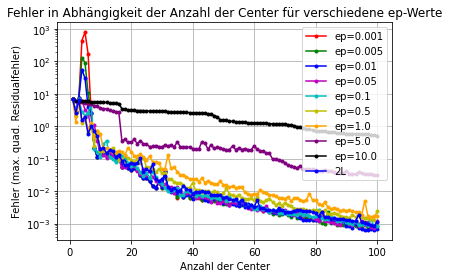

Kleinster MSE von VKOGA mit  5.981e-05 von ep Wert:  0.1
Kleinster MSE von 2L-VKOGA mit  6.833e-05


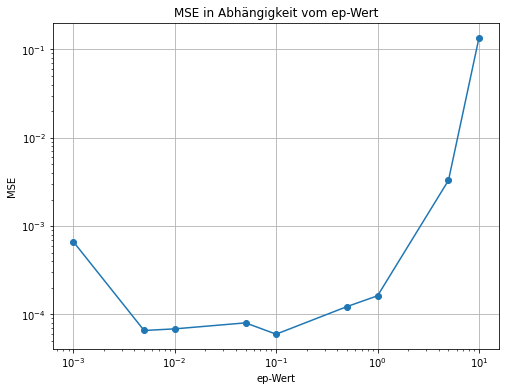

In [7]:
ep_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple', 'k', 'b']
mse_list = []

for i, ep in enumerate(ep_values):
    model = VKOGA_2L(
        kernel=kernels.Matern(k=1, ep=ep),
        flag_2L_optimization=False,
        verbose=False,
        greedy_type='f_greedy',
        reg_par=0,
        restr_par=1e-2,
        tol_f=1e-10,
        tol_p=1e-10,
        reg_para_optim=1e-5,
        learning_rate=5e-3,
        n_epochs_optim=100,
        batch_size=32,
        flag_optim_verbose=False
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test).flatten()
    mse = np.mean((predictions - y_test.numpy()) ** 2)
    mse_list.append(mse)
    plt.plot(model.train_hist['n'], model.train_hist['f'], marker='.', color=colors[i], label=f'ep={ep}')
plt.plot(model_2L.train_hist['n'], model_2L.train_hist['f'], marker='.', color=colors[-1], label=f'2L')

plt.xlabel('Anzahl der Center')
plt.ylabel('Fehler (max. quad. Residualfehler)')
plt.title('Fehler in Abhängigkeit der Anzahl der Center für verschiedene ep-Werte')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

min_mse = min(mse_list)
best_ep = mse_list.index(min_mse)
print("Kleinster MSE von VKOGA mit ", min_mse.round(decimals=8), "von ep Wert: ", ep_values[best_ep])
print("Kleinster MSE von 2L-VKOGA mit ", mse_2L.round(decimals=8))
plt.figure(figsize=(8, 6))
plt.plot(ep_values, mse_list, marker='o', linestyle='-')
plt.xlabel("ep-Wert")
plt.ylabel("MSE")
plt.title("MSE in Abhängigkeit vom ep-Wert")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
X, y = generate_data(size=(50000, 4), function=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X[:5])
print(y[:5])

tensor([[0.5261, 0.1579, 0.6732, 0.5689],
        [0.1831, 0.2568, 0.9708, 0.6729],
        [0.5633, 0.6340, 0.9191, 0.0761],
        [0.3028, 0.8678, 0.2105, 0.1667],
        [0.0090, 0.1670, 0.7456, 0.5059]])
tensor([ 1.4692,  9.7381,  0.4789,  1.3575, 96.9949])


In [9]:
# Initialize and fit VKOGA_2L model
model_2L = VKOGA_2L(
    kernel=[kernels.Matern(k=1), tkernels.Matern(k=1)], # quadratic Matern kernel used
    flag_2L_optimization=True,
    verbose=False,
    greedy_type='f_greedy',
    reg_par=0,
    restr_par=1e-2,
    tol_f=1e-10,
    tol_p=1e-10,
    reg_para_optim=1e-5,
    learning_rate=5e-3,
    n_epochs_optim=25,
    batch_size=64,
    flag_optim_verbose=False
)

model_2L.fit(X_train, y_train)

# Print some predictions and ground truth
predictions = model_2L.predict(X_test)
predictions = predictions.flatten()
print("Predictions:", predictions[:5])
print("Ground truth:", y_test[:5])

# Print Error
mse_2L = np.mean((predictions - y_test.numpy()) ** 2)
print(f"MSE on Test Data: {mse_2L.round(decimals=4)}")
print(f"Transformationmatrix: {model_2L.A.round(decimals=3)}")
U, S, VT = np.linalg.svd(model_2L.A.round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))

Predictions: [ 2.0082643  20.4204868   1.0289163  26.79195863  1.70253978]
Ground truth: tensor([ 2.0675, 19.2938,  0.5536, 25.3983,  1.3068])
MSE on Test Data: 3.6647
Transformationmatrix: [[ 1.977e+00  1.430e-01 -1.630e-01 -1.000e-02]
 [-7.000e-03 -8.000e-03 -1.650e-01  8.000e-02]
 [ 1.000e-02  1.600e-02  1.000e-03 -2.100e-02]
 [-3.000e-02 -3.700e-02  1.800e-02  2.820e-01]]
Singulärwerte (S): [1.989 0.298 0.162 0.013]
Linke singuläre Vektoren (U):
 [[-1.     0.016  0.009  0.004]
 [-0.003  0.347 -0.938 -0.017]
 [-0.006 -0.076 -0.01  -0.997]
 [ 0.018  0.935  0.347 -0.075]]
Rechte singuläre Vektoren (V^T):
 [[-0.994 -0.072  0.082  0.008]
 [ 0.004 -0.121 -0.145  0.982]
 [ 0.085 -0.026  0.986  0.142]
 [ 0.07  -0.99  -0.014 -0.125]]


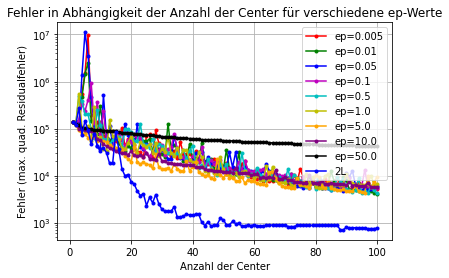

Kleinster MSE von VKOGA mit  254.1039 von ep Wert:  5.0
Kleinster MSE von 2L-VKOGA mit  3.6647


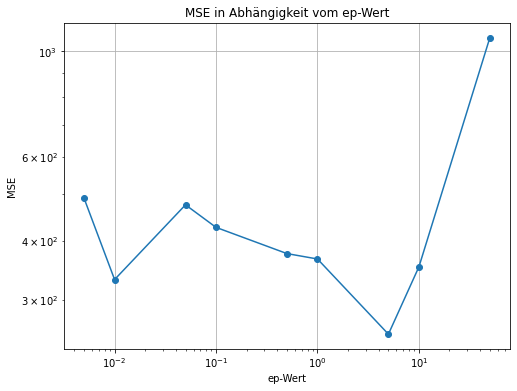

In [10]:
ep_values = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple', 'k', 'b']
mse_list = []

for i, ep in enumerate(ep_values):
    model = VKOGA_2L(
        kernel=kernels.Matern(k=1, ep=ep),
        flag_2L_optimization=False,
        verbose=False,
        greedy_type='f_greedy',
        reg_par=0,
        restr_par=1e-2,
        tol_f=1e-10,
        tol_p=1e-10,
        reg_para_optim=1e-5,
        learning_rate=5e-3,
        n_epochs_optim=100,
        batch_size=32,
        flag_optim_verbose=False
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test).flatten()
    mse = np.mean((predictions - y_test.numpy()) ** 2)
    mse_list.append(mse)
    plt.plot(model.train_hist['n'], model.train_hist['f'], marker='.', color=colors[i], label=f'ep={ep}')
plt.plot(model_2L.train_hist['n'], model_2L.train_hist['f'], marker='.', color=colors[-1], label=f'2L')

plt.xlabel('Anzahl der Center')
plt.ylabel('Fehler (max. quad. Residualfehler)')
plt.title('Fehler in Abhängigkeit der Anzahl der Center für verschiedene ep-Werte')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

min_mse = min(mse_list)
best_ep = mse_list.index(min_mse)
print("Kleinster MSE von VKOGA mit ", min_mse.round(decimals=4), "von ep Wert: ", ep_values[best_ep])
print("Kleinster MSE von 2L-VKOGA mit ", mse_2L.round(decimals=4))
plt.figure(figsize=(8, 6))
plt.plot(ep_values, mse_list, marker='o', linestyle='-')
plt.xlabel("ep-Wert")
plt.ylabel("MSE")
plt.title("MSE in Abhängigkeit vom ep-Wert")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()